In [1]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[0]

<class 'bs4.element.ResultSet'>
120


In [2]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-07-16 23:10
https://minneapolis.craigslist.org/hnp/apa/d/summer-special-great-apt-east-st-paul/7157887629.html


In [3]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



 (1467 E. 7th St., St. Paul, Mn 55106)


In [4]:
from geopy.geocoders import Nominatim, ArcGIS
curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
geolocator = Nominatim(user_agent="darren")

print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])

location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])


geolocator2 = ArcGIS(user_agent="darren")
location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
                                distance=500)





import numpy as np

loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
                   +","
                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
    
print(location.address)
print(location2.address)
print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

44.967166,-93.037591
1491, East 7th Street, St. Paul, Ramsey County, Minnesota, 55106, United States of America
1485 7th St E, Saint Paul, Minnesota 55106, USA
1458, East 7th Street, St. Paul, Ramsey County, Minnesota, 55106, United States of America


In [5]:
curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
print(curmap)

[<div class="mapbox">
<div class="viewposting" data-accuracy="99" data-latitude="44.967166" data-longitude="-93.037591" id="map"></div>
</div>]


In [6]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [7]:
#linkpfx = 'https://minneapolis.craigslist.org/search/apa?'
#linksfx =( 'sort=date'
#          +'&hasPic=1'
#          +'&bundleDuplicates=1'
#          +'&search_distance=20'
#          +'&postal=55454'
#          +'&min_price=500'
#          +'&max_price=4000'
#          +'&max_bedrooms=3'
#          +'&availabilityMode=0'
#          +'&sale_date=all+dates')
#response = get(linkpfx+linksfx)
#html_soup = BeautifulSoup(response.text, 'html.parser')
#results_num = html_soup.find('div', class_= 'search-legend')
#results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
#pages = np.arange(0, results_total+1, 120)
#print(results_total)
#print(pages)

#post.find('a', class_='result-title hdrlnk')['href'] in post_links
#post.find('a', class_='result-title hdrlnk')['href'] in 
#apts['URL'].str.contains(post.find('a', class_='result-title hdrlnk')['href']).sum()
#apts['URL'].str.contains('https://minneapolis.craigslist.org/dak/apa/d/burnsville-end-unit-2-bedroom-townhouse/7135839874.html').sum()

In [8]:
#build out the loop
from bs4 import BeautifulSoup
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np

import requests


citystr = 'minneapolis' ## 'washingtondc' #'minneapolis'
linkpfx = 'https://'+citystr+'.craigslist.org/search/apa?'
linksfx =( 'sort=date'
          +'&hasPic=1'
          +'&bundleDuplicates=1'
          +'&search_distance=7'
          +'&postal=55454' #55454' #DC: 20009
          +'&min_price=300'
          +'&max_price=8000'
          +'&max_bedrooms=4'
          +'&availabilityMode=0'
          +'&sale_date=all+dates')
response = get(linkpfx+linksfx)
html_soup = BeautifulSoup(response.text, 'html.parser')
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array
pages = np.arange(0, results_total+1, 120)


from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=5)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get(linkpfx
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + linksfx)    
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap and (
        post.find('a', class_='result-title hdrlnk')['href'] not in post_links):

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

#drop duplicates
apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

apts.to_csv(path_or_buf='./scraped_data/apts_'+citystr+"_"+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
apts.shape


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


(103, 14)

In [9]:
##drop duplicates
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
#
##make the number bedrooms to a float (since np.nan is a float too)
#apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))
#
##convert datetime string into datetime object to be able to work with it
#from datetime import datetime
#
#apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data

#apts.to_csv(path_or_buf='./apts_'+str(datetime.now()).replace(' ','_').replace(':','-')+'.csv', index=False)
#apts.shape

In [10]:
import os
import glob
citystr = 'minneapolis' #'minneapolis', 'washingtondc'

aptfiles = glob.glob('./scraped_data/apts_'+citystr+'*')


try:
    del apts
except:
    print('no apts in memory, loading some...')


for file in aptfiles:
    try: 
        apts = apts.append(pd.read_csv(file),ignore_index=True)
    except:
        apts = pd.read_csv(file)
#apts = apts.drop_duplicates(subset=['URL','sqft','number bedrooms'])
apts = apts.drop_duplicates(subset=['price','sqft','number bedrooms','laundry','parking','zips','types','neighborhoods'])
apts = apts[apts['sqft']>400]
apts = apts[apts['sqft']<2000]
apts = apts[apts['price']>559]
apts = apts[apts['price']<2500]
apts = apts[apts['price'] / apts['number bedrooms'] > 400]

print(str(apts.shape[0])+' unique listings found.')

3396 unique listings found.


In [11]:
from operator import itemgetter
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=False)
apt = apts.iloc[0]
zipcode = search.by_zipcode(str(apt['zips']))
zipDict = zipcode.to_dict()
NaN = np.nan
if 'medianIncome' not in apts.columns:
    apts['medianIncome'] = NaN
    apts = pd.concat([apts,pd.DataFrame(columns=list(map(itemgetter('x'), zipDict['population_by_age'][2]['values'])))])
    apts['medianHomeValue'] = NaN
    

print(apts.columns)

Index(['posted', 'neighborhood', 'post title', 'number bedrooms', 'sqft',
       'URL', 'price', 'cities', 'towns', 'neighborhoods', 'zips', 'types',
       'parking', 'laundry', 'medianIncome', 'Under 5', '5-9', '10-14',
       '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
       '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 Plus',
       'medianHomeValue'],
      dtype='object')


In [12]:

#index = 0
#apt = apts.iloc[index]
#zipcode = search.by_zipcode(str(apt['zips']))
#zipDict = zipcode.to_dict()
#income = np.float(zipDict['median_household_income'])
#popsByAge = np.array(list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] )) ) / zipDict['population']
#
#apts.loc[index,'medianIncome'] = income
#apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = popsByAge
#print(apts.iloc[0])
#
    

    
for index, apt in apts.iterrows():
    zipcode = search.by_zipcode(str(apt['zips']))
    zipDict = zipcode.to_dict()
    income = zipDict['median_household_income']
    if income is not None:
        apts.loc[index,'medianIncome'] = np.float(income)
        
    homeValue = zipDict['median_home_value']
    if homeValue is not None:
        apts.loc[index,'medianHomeValue'] = np.float(income)
        
    if zipDict['population_by_age'] is not None:
        popsByAge = list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] ))
        apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = np.array(popsByAge) / zipDict['population']

apts['pKids'] = apts[['Under 5', '5-9', '10-14']].sum(axis=1)
apts['pYouths'] = apts[['15-19']].sum(axis=1)
apts['pEarlyTwenties'] = apts[['20-24']].sum(axis=1)
apts['pLateTwenties'] = apts[['25-29']].sum(axis=1)
apts['pEarlyThirties'] = apts[['30-34']].sum(axis=1)
apts['pLateThirties'] = apts[['35-39']].sum(axis=1)
apts['pEarlyForties'] = apts[['40-44']].sum(axis=1)
apts['pLateForties'] = apts[['45-49']].sum(axis=1)
apts['pFifties'] = apts[['50-54','55-59']].sum(axis=1)
apts['pSixtyPlus'] = apts[['60-64','65-69','70-74','75-79','80-84','85 Plus']].sum(axis=1)

In [13]:
search = SearchEngine(simple_zipcode=False)
apt = apts.iloc[0]
zipcode = search.by_zipcode(str(apt['zips']))
zipDict = zipcode.to_dict()
zipDict['population']

44356

In [14]:
#from walkscore import WalkScoreAPI
#api_key = 'YOUR API KEY GOES HERE'
#
#walkscore_api = WalkScoreAPI(api_key = api_key)

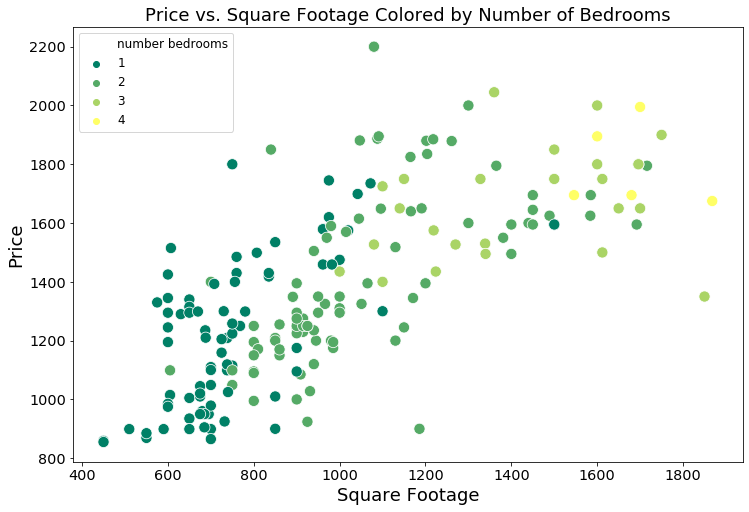

In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


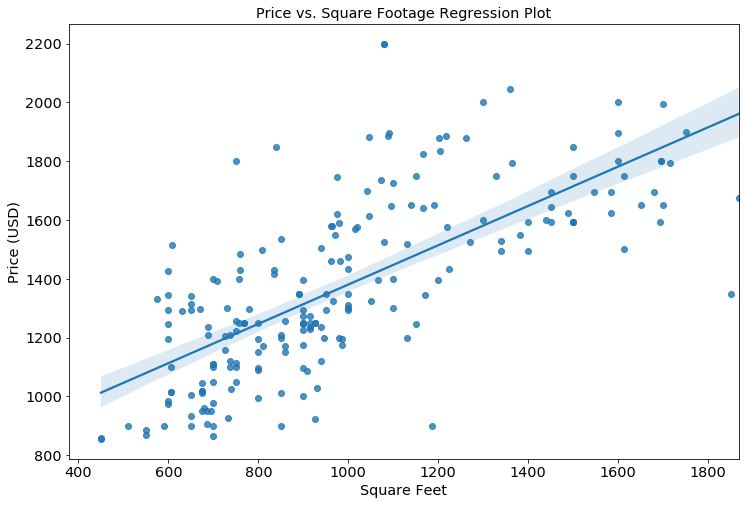

In [16]:
plt.figure(figsize=(12, 8))
sns.regplot(x='sqft', y='price', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Square Feet");
plt.ylabel("Price (USD)");

In [17]:
apts.corr()

number bedrooms      sqft     price     types   parking  \
number bedrooms         1.000000  0.796700  0.494127  0.374628  0.058245   
sqft                    0.796700  1.000000  0.595272  0.477983 -0.111594   
price                   0.494127  0.595272  1.000000  0.188353 -0.387415   
types                   0.374628  0.477983  0.188353  1.000000 -0.077421   
parking                 0.058245 -0.111594 -0.387415 -0.077421  1.000000   
laundry                -0.029133 -0.183038 -0.545062 -0.143481  0.592335   
medianIncome            0.037536  0.175739  0.090855  0.120168 -0.202062   
medianHomeValue         0.037410  0.175683  0.090406  0.120052 -0.201737   
pKids                   0.119322  0.114407 -0.153563  0.138366  0.156366   
pYouths                 0.131576  0.045612 -0.073426  0.105708  0.167859   
pEarlyTwenties          0.019608 -0.092807  0.048960 -0.023400  0.115289   
pLateTwenties          -0.144549 -0.165085  0.150883 -0.126266 -0.031747   
pEarlyThirties         -0.121489 -0.131367  0.124475 -0.080790 -0.025078   
pLateThirties          -0.050685 -0.051334  0.053440  0.005299  0.014751   
pEarlyForties           0.010171  0.030458  0.010306  0.079882  0.019390   
pLateForties            0.027394  0.064422 -0.013148  0.106704 -0.021687   
pFifties                0.013167  0.053073 -0.011174  0.080071 -0.023883   
pSixtyPlus             -0.027299  0.021646 -0.020261 -0.009050 -0.063573   

                  laundry  medianIncome  medianHomeValue     pKids   pYouths  \
number bedrooms -0.029133      0.037536         0.037410  0.119322  0.131576   
sqft            -0.183038      0.175739         0.175683  0.114407  0.045612   
price           -0.545062      0.090855         0.090406 -0.153563 -0.073426   
types           -0.143481      0.120168         0.120052  0.138366  0.105708   
parking          0.592335     -0.202062        -0.201737  0.156366  0.167859   
laundry          1.000000     -0.134466        -0.134182  0.109051  0.054238   
medianIncome    -0.134466      1.000000         1.000000  0.285947 -0.045357   
medianHomeValue -0.134182      1.000000         1.000000  0.284796 -0.046557   
pKids            0.109051      0.285947         0.284796  1.000000  0.352595   
pYouths          0.054238     -0.045357        -0.046557  0.352595  1.000000   
pEarlyTwenties  -0.028539     -0.566043        -0.565712 -0.089819  0.659099   
pLateTwenties   -0.104894     -0.408904        -0.408099  0.006832 -0.120579   
pEarlyThirties  -0.102051     -0.229170        -0.228833  0.232281 -0.102393   
pLateThirties   -0.069752      0.165210         0.168670  0.579126  0.048921   
pEarlyForties   -0.052320      0.646279         0.649155  0.753397  0.167569   
pLateForties    -0.057537      0.720522         0.721775  0.746499  0.214456   
pFifties        -0.051006      0.649951         0.650504  0.682837  0.201442   
pSixtyPlus      -0.023756      0.233983         0.232963  0.467242  0.097223   

                 pEarlyTwenties  pLateTwenties  pEarlyThirties  pLateThirties  \
number bedrooms        0.019608      -0.144549       -0.121489      -0.050685   
sqft                  -0.092807      -0.165085       -0.131367      -0.051334   
price                  0.048960       0.150883        0.124475       0.053440   
types                 -0.023400      -0.126266       -0.080790       0.005299   
parking                0.115289      -0.031747       -0.025078       0.014751   
laundry               -0.028539      -0.104894       -0.102051      -0.069752   
medianIncome          -0.566043      -0.408904       -0.229170       0.165210   
medianHomeValue       -0.565712      -0.408099       -0.228833       0.168670   
pKids                 -0.089819       0.006832        0.232281       0.579126   
pYouths                0.659099      -0.120579       -0.102393       0.048921   
pEarlyTwenties         1.000000       0.416877        0.266632       0.132347   
pLateTwenties          0.416877       1.000000        0.937280       0.726954  

In [18]:
apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()

number bedrooms    sqft   price  types  parking  laundry  \
neighborhoods                                                             
Anoka                      1.0   735.0  1060.0    1.0      NaN      4.0   
Apple Valley               1.0   857.0  1307.0    1.0      2.0      1.0   
Aquila                     1.0   750.0  1000.0    1.0      3.0      3.0   
Audubon Park               1.0   800.0   890.0    1.5      3.0      3.0   
Autumn Woods               1.0  1342.0  1885.0    1.0      2.0      1.0   
...                        ...     ...     ...    ...      ...      ...   
Whittier                   1.0   560.0  1025.0    1.0      4.0      3.0   
Willow Park                1.0   739.5  1562.5    1.0      2.0      1.0   
Windom                     1.0   650.0   925.0    1.0      4.0      3.0   
Windom Park                1.0   535.0  1150.0    1.0      4.0      3.0   
Woodbury                   1.0   806.5  1424.5    5.0      2.0      1.0   

               medianIncome  medianHomeValue     pKids   pYouths  \
neighborhoods                                                      
Anoka               68130.0          68130.0  0.214166  0.072597   
Apple Valley        82990.0          82990.0  0.227095  0.071644   
Aquila              63699.0          63699.0  0.159190  0.042854   
Audubon Park        55486.0          55486.0  0.172401  0.047740   
Autumn Woods       102759.0         102759.0  0.243626  0.077844   
...                     ...              ...       ...       ...   
Whittier            43178.0          43178.0  0.145092  0.037657   
Willow Park         63699.0          63699.0  0.159190  0.042854   
Windom              94177.0          94177.0  0.209839  0.051352   
Windom Park         55486.0          55486.0  0.172401  0.047740   
Woodbury            99620.0          99620.0  0.259517  0.064315   

               pEarlyTwenties  pLateTwenties  pEarlyThirties  pLateThirties  \
neighborhoods                                                                 
Anoka                0.058401       0.067117        0.068692       0.070547   
Apple Valley         0.049652       0.062242        0.070709       0.071847   
Aquila               0.067027       0.124634        0.093606       0.064221   
Audubon Park         0.063179       0.097414        0.099281       0.080110   
Autumn Woods         0.034343       0.048704        0.051046       0.063690   
...                       ...            ...             ...            ...   
Whittier             0.134118       0.165920        0.101875       0.072026   
Willow Park          0.067027       0.124634        0.093606       0.064221   
Windom               0.039234       0.071915        0.078694       0.079073   
Windom Park          0.063179       0.097414        0.099281       0.080110   
Woodbury             0.041386       0.065057        0.072514       0.080194   

               pEarlyForties  pLateForties  pFifties  pSixtyPlus  
neighborhoods                                                     
Anoka               0.078055      0.085541  0.136952    0.147933  
Apple Valley        0.080182      0.087218  0.143295    0.136116  
Aquila              0.062538      0.065785  0.124875    0.195270  
Audubon Park        0.069999      0.070508  0.136061    0.163308  
Autumn Woods        0.091581      0.111978  0.160423    0.116766  
...                      ...           ...       ...         ...  
Whittier            0.062740      0.055824  0.096235    0.104730  
Willow Park         0.062538      0.065785  0.124875    0.195270  
Windom              0.084488      0.079830  0.148110    0.157464  
Windom Park         0.069999      0.070508  0.136061    0.163308  
Woodbury            0.088841      0.084427  0.126645    0.117106  

[117 rows x 18 columns]

In [19]:
#apts[apts['number bedrooms']<=1].groupby('neighborhoods').median()['price'].sort_values()

In [20]:
#apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()

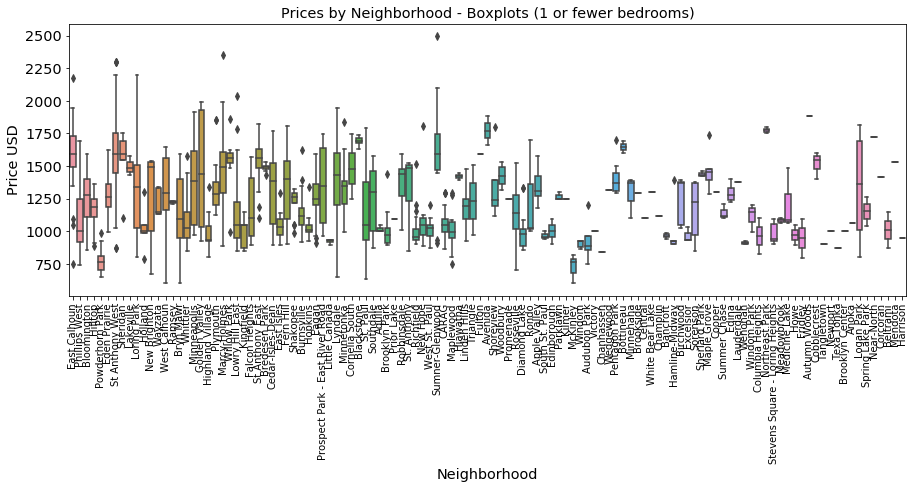

In [21]:
brlim = 1
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=brlim])
            #order=sorted(apts[apts['number bedrooms']<=brlim]['neighborhoods'].unique()))
plt.xlabel("Neighborhood");
plt.xticks(rotation=90,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots ("+str(brlim)+" or fewer bedrooms)");

In [22]:
# drop problematic cols
apts = apts.dropna(subset=['price','number bedrooms','sqft','neighborhoods','types','laundry','parking',
                           'medianIncome','medianHomeValue','pKids','pYouths','pEarlyTwenties','pLateTwenties',
                           'pEarlyThirties','pLateThirties','pEarlyForties','pLateForties','pFifties','pSixtyPlus'])
print(apts.shape)

# recode neighborhoods
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['cities'], prefix = ['ct'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pk'])
apts_onehot['parking'] = apts['parking']
apts_onehot['laundry'] = apts['laundry']
apts_onehot['cities'] = apts['cities']
apts_onehot['neighborhoods'] = apts['neighborhoods']

#print(apts_onehot)

(2708, 44)


In [23]:
from sklearn import preprocessing
from sklearn import linear_model

maincols = ['number bedrooms','sqft','medianIncome','medianHomeValue',
            'pKids','pYouths',
            'pEarlyTwenties','pLateTwenties',
            'pEarlyThirties','pLateThirties',
            'pEarlyForties','pLateForties',
            'pFifties','pSixtyPlus']
#nbcols = [col for col in apts_onehot if col.startswith('ct')]
#for c in nbcols:
#    maincols.append(c) 
#nbcols = [col for col in apts_onehot if col.startswith('nb')]
#for c in nbcols:
#    maincols.append(c) 
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in tycols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in pkcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in ldcols:
    maincols.append(c) 

# set up regression
y = apts_onehot['price'].values.reshape(-1,1)
X = apts_onehot[maincols].values
thresh = .5 # drop columns that correlate above this value
cor = np.abs(np.corrcoef(X.T))
p = np.argwhere(np.triu(np.isclose(cor,1),1))
X = np.delete(X,p[:,1],axis=1)
X = preprocessing.scale(X)
print("Number observations: "+str(X.shape[0]))

#OLS
reg = linear_model.LinearRegression()
reg.fit(y=y,X=X)
apts_onehot['price_est'] = np.zeros((apts_onehot.shape[0],1))
apts_onehot['price_est'] = reg.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100

# Ridge regression approach
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha': [.005, .01, .025, .05, .10, .5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=10)
ridge_regressor.fit(X=X,y=y)
print("Ridge params (best): "+str(ridge_regressor.best_params_))
print("Ridge score (best): "+str(ridge_regressor.best_score_))
apts_onehot['price_est'] = ridge_regressor.predict(X)
apts_onehot['price_dif'] = apts_onehot['price']-apts_onehot['price_est']
apts_onehot['price_difpct'] = (apts_onehot['price_dif'] / apts_onehot['price_est']) * 100


Number observations: 2708
Ridge params (best): {'alpha': 32}
Ridge score (best): -44472.70620149658


In [24]:
#pd.options.display.max_colwidth = 200
#pd.options.display.max_rows = 600
#
#apts_onehot[(apts_onehot['price_difpct']<=10) & 
#            (apts_onehot['sqft']>=699) & 
#            (apts_onehot['price']<=1200) & 
#            (apts_onehot['number bedrooms']<=2)].sort_values('price_difpct',ascending=True)[['URL','price_difpct']] 

In [25]:
#Prepare data:
prices = np.array(apts_onehot['price'])
features = np.array(apts_onehot[maincols])
feature_list = list(apts_onehot[maincols])

In [26]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, prices, test_size = 0.20, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2166, 34)
Training Labels Shape: (2166,)
Testing Features Shape: (542, 34)
Testing Labels Shape: (542,)


In [27]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [28]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error: $', round(np.mean(errors), 2), '.')

Mean Absolute Error: $ 127.74 .


In [29]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 90.91 %.


In [30]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


In [31]:
from IPython.display import Image 
Image("tree.png")

In [32]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sqft                 Importance: 0.51
Variable: ld_1.0               Importance: 0.19
Variable: pKids                Importance: 0.05
Variable: number bedrooms      Importance: 0.04
Variable: pYouths              Importance: 0.03
Variable: pLateTwenties        Importance: 0.02
Variable: pEarlyThirties       Importance: 0.02
Variable: pLateThirties        Importance: 0.02
Variable: medianIncome         Importance: 0.01
Variable: medianHomeValue      Importance: 0.01
Variable: pEarlyTwenties       Importance: 0.01
Variable: pEarlyForties        Importance: 0.01
Variable: pLateForties         Importance: 0.01
Variable: pFifties             Importance: 0.01
Variable: pSixtyPlus           Importance: 0.01
Variable: ty_1.0               Importance: 0.01
Variable: ty_4.0               Importance: 0.01
Variable: ty_6.0               Importance: 0.01
Variable: pk_2.0               Importance: 0.01
Variable: pk_4.0               Importance: 0.01
Variable: ty_2.0               Importanc

In [33]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 600

apts_onehot['price_est_rf'] = rf.predict(features)
apts_onehot['price_dif_rf'] = apts_onehot['price']-apts_onehot['price_est_rf']
apts_onehot['price_difpct_rf'] = (apts_onehot['price_dif_rf'] / apts_onehot['price_est_rf']) * 100
apts_onehot['price_difpct_avg'] = apts_onehot[['price_difpct','price_difpct_rf']].mean(axis=1)

apts_onehot[(apts_onehot['price_difpct_avg']<=25) & 
            (apts_onehot['parking'] <=4 ) &
            ((apts_onehot['laundry']==1) | (apts_onehot['laundry']==3) | (apts_onehot['laundry']==4)) & 
            (apts_onehot['sqft']>=450) & 
            (apts_onehot['price']<=1500) & 
            ((apts_onehot['cities']=='Minneapolis') | (apts_onehot['cities']=='Robbinsdale') |
             (apts_onehot['cities']=='Saint Louis Park') | (apts_onehot['cities']=='Richfield') |
             (apts_onehot['cities']=='St. Anthony') | (apts_onehot['cities']=='St. Paul') | 
             (apts_onehot['cities']=='New Brighton') | (apts_onehot['cities']=='Edina')) &
            (apts_onehot.index>=np.round(np.percentile(apts_onehot.index,95)))].sort_values('posted',ascending=False)[['posted','neighborhoods','URL','price_difpct','price_difpct_rf','price_difpct_avg']] 

posted     neighborhoods  \
9092  2020-07-16 22:54:00          Whittier   
9011  2020-07-16 19:23:00  Highland Village   
9013  2020-07-16 19:10:00          Harrison   
9018  2020-07-16 18:23:00          Standish   
9038  2020-07-16 17:34:00          St. Paul   
9054  2020-07-16 16:54:00   Powderhorn Park   
9058  2020-07-16 16:48:00      Marcy-Holmes   
8883  2020-07-16 16:18:00           Central   
8884  2020-07-16 16:04:00          Whittier   
8776  2020-07-16 15:43:00             CARAG   
8778  2020-07-16 15:41:00        East Isles   
8787  2020-07-16 15:24:00         Richfield   
8796  2020-07-16 15:09:00         Richfield   
8820  2020-07-16 14:36:00   Lowry Hill East   
8826  2020-07-16 14:31:00         Fern Hill   
8827  2020-07-16 14:29:00         Fern Hill   
8828  2020-07-16 14:28:00         Fern Hill   
8836  2020-07-16 14:20:00     Phillips West   
8835  2020-07-16 14:20:00             CARAG   
8844  2020-07-16 14:14:00      Marcy-Holmes   
8663  2020-07-16 14:04:00         Fern Hill   
8672  2020-07-16 13:56:00          Whittier   
8676  2020-07-16 13:55:00  Marshall Terrace   
8689  2020-07-16 13:38:00       Loring Park   
8712  2020-07-16 12:59:00   Lowry Hill East   
8717  2020-07-16 12:49:00  Highland Village   
8545  2020-07-16 12:35:00         Southdale   
8583  2020-07-16 12:15:00   St Anthony West   
8586  2020-07-16 12:13:00       Loring Park   
8602  2020-07-16 12:02:00      Marcy-Holmes   
8609  2020-07-16 12:00:00           Lyndale   
8611  2020-07-16 11:58:00             CARAG   
8452  2020-07-16 11:43:00             CARAG   
8453  2020-07-16 11:43:00           Lyndale   
8457  2020-07-16 11:41:00         Bryn Mawr   
8460  2020-07-16 11:41:00   St Anthony West   
8470  2020-07-16 11:33:00       Loring Park   
8496  2020-07-16 10:46:00          St. Paul   
8360  2020-07-16 10:35:00      Marcy-Holmes   
8359  2020-07-16 10:35:00         Fern Hill   
8365  2020-07-16 10:29:00   St Anthony West   
8374  2020-07-16 10:19:00          Whittier   
8378  2020-07-16 10:16:00      West Calhoun   
8310  2020-07-16 09:09:00          Triangle   
8344  2020-07-16 08:11:00   St Anthony East   
8348  2020-07-16 08:10:00        Logan Park   
8347  2020-07-16 08:10:00   Powderhorn Park   
8350  2020-07-16 08:07:00          St. Paul   
8356  2020-07-16 07:51:00     Phillips West   

                                                                                                        URL  \
9092       https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-whittier-1-br-available/7159552060.html   
9011   https://minneapolis.craigslist.org/ram/apa/d/saint-paul-one-bedroom-garden-apartment/7155646685.html   
9013   https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-luxe-1-bedroom-7-minutes-to/7155281706.html   
9018           https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-side-by-side-duplex/7160657106.html   
9038            https://minneapolis.craigslist.org/ram/apa/d/saint-paul-2-bedroom-apartment/7160584230.html   
9054    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-lovely-3-bedroom-apartment/7158785599.html   
9058     https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-1-bed-1-bath-apartment-in/7155921811.html   
8883        https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-free-laundry-2-bed-pet/7160587583.html   
8884        https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-beautiful-contemporary/7160578440.html   
8776    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-nice-location-garden-level/7144802178.html   
8778    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-beautiful-uptown-2-bedroom/7160563687.html   
8787         https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-grilling-picnic-areas/7160530553.html   
8796       https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-controlled-access-entry/7160532985.html   
8820    https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-video-tour-available-large/7160519914.html   
882

In [34]:
query_address = "2310 Aldrich Avenue South, Minneapolis 55405"
nbr = 1
#sqft = 